# Usando clusterização para decidir onde morar

![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c7/Mapa_de_Jo%C3%A3o_Pessoa_e_regi%C3%B5es_pr%C3%B3ximas.jpg/735px-Mapa_de_Jo%C3%A3o_Pessoa_e_regi%C3%B5es_pr%C3%B3ximas.jpg)

Em 2023 entrei no regime 100% Home Office, nesse contexto decidir por escolher uma cidade que pudesse me atender melhor nas coisas que desejava na vida, depois de testar morar por  alguns lugares no Brasil ao longo desse ano decidi que esse lugar iria ser João Pessoa na Paraíba. Agora eu tinha que enfim alugar um apartamento...

>... **mas onde? Baseado em que eu faria essa decisão? Do que eu preciso perto desse lugar para atender as minhas necessidades cotidianas?**

A resolução desse problema é o que vocês verão na sequência.

A proposta de resolução passa pelas seguintes etapas:

- Coleta de dados. Através dos pacotes osmnx e googlemaps (API python do Google Maps), coletando as informações de limites geográficos da cidade (ruas e afins) e os pontos de interesse (Facilities), respectivamente.
- Seccionar os limites geográficos em hexágonos  e interseccionar com os pontos comerciais de interesse.
- Contabilizar  esses pontos de interesse por hexágono e ponderar a minha importância pessoal para cada tipo deles.
- Clusterizar essa tabela de pontos de interesse ponderados e decidir dentre uma lista de endereços de interesse as melhores regiões.

# Funções

Para deixar as coisas mais organizadas e objetivas eu montei uma série de funções que foram responsáveis pela coleta e o processamento geográfico, se essa parte for do seu interesse eu tive o cuidado de deixar o que cada uma faz da forma mais clara e documentada o possível. Dentre elas a obteção da chave para usar a API do Google Maps é a que julguei que pode precisar de um pouco mais de empenho, a coleta não é a principal questão que quero abordar hoje, porém vou deixar esse [link](https://developers.google.com/maps/documentation/places/web-service/overview) para você explorar e você vai precisar ter uma conta no [serviço de Cloud do Google](https://cloud.google.com) para prosseguir.

Imports

In [ ]:
# !pip install h3==3.7.6
# !pip install osmnx==1.9.1 
# !pip install googlemaps==4.10.0
# !pip install pandas==1.5.3
# !pip install geopandas==0.13.2
# !pip install shapely==2.0.3
# !pip install matplotlib==2.0.3
# !pip install geopy==2.4.1
# !pip install seaborn==0.13.2
# !pip install plotly==5.21.0
# !pip install yellowbrick==1.5
# !pip install scikit-learn==1.4.2

In [8]:

from geopy.geocoders import Nominatim
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, Point, mapping, LineString
import matplotlib.pyplot as plt
import osmnx as ox
import h3
import numpy as np

import seaborn as sns

# import googlemaps
# from google.colab import userdata
# import networkx as nx
# import folium



In [11]:
def get_coordinates(endereco: str)-> tuple:
  """
  Retorna as coordenadas geográficas de um endereço.

  Args:
    endereco: O endereço a ser pesquisado.

  Returns:
    Um tuple com as coordenadas geográficas (latitude, longitude).
  """

  geolocator = Nominatim(user_agent="test_app")
  location = geolocator.geocode(endereco)

  if location:
    return location.latitude, location.longitude
  else:
    return None #Isso pode dar problemas quando transformar para uma objeto geográfico

def create_geo_address(enderecos: list, crs: str ='EPSG:4326') -> gpd.GeoDataFrame:
  """
  Cria um GeoDataFrame a partir de uma lista de endereços.

  Args:
    enderecos: Uma lista de endereços.

  Returns:
    Um GeoDataFrame com as coordenadas geográficas dos endereços.
  """

  # Lista de tuplas com coordenadas (latitude, longitude)
  coordenadas = [get_coordinates(i) for i in enderecos]
  # Criar uma lista de objetos Point a partir das coordenadas
  geometry = [Point(longitude, latitude) for latitude, longitude in coordenadas]
  # Criar um GeoDataFrame com as listas
  enderecos_gpd = gpd.GeoDataFrame({'Endereços': enderecos, 'geometry': geometry}, crs='EPSG:4326')
  # Imprimir o GeoDataFrame
  enderecos_gpd = enderecos_gpd.reset_index()
  return enderecos_gpd

def create_geo_objects_city(place_name: str) -> gpd.GeoDataFrame:
  """
  Cria arquivos geográficos através do nome de uma cidade indicada

  Args:
    place_name: Nome da cidade.

  Returns:
    geodataframes nodes_proj, edges_proj e area
  """
  graph = ox.graph_from_place(place_name)
  nodes_proj, edges_proj = ox.graph_to_gdfs(graph, nodes=True, edges=True)
  area = ox.geocode_to_gdf(place_name)

  # buffered_area = area.copy()  # Criar uma cópia do GeoDataFrame original para evitar modificar o original
  # buffered_area['geometry'] = area.buffer(2000)  # O argumento representa a distância do buffer em metros (2 km = 2000 metros)
  # buffered_area.crs = area.crs

  return nodes_proj, edges_proj, area #, buffered_area

def give_facilities_googlemaps(key: str, latitude: float ,longitude: float , radius: int , type: str) -> gpd.GeoDataFrame:
  """
  Buscas através de uma API do Google Maps dentro do raio especificado de uma coordenada um tipo de estabelicimento solicitado
  Args:
    key: Chave de acesso a API
    latitude: latitude geográfica
    longitude: longitude geográfica
    radius: Raio de busca em metros
    type: Tipo de estabelecimento a ser buscado (https://developers.google.com/maps/documentation/places/web-service/place-types)

  Returns:
    geodataframe com a lista de estabelecimento em detalhes
  """
  gmaps = googlemaps.Client(key=key)
  places = gmaps.places_nearby(
      location=(latitude, longitude),  # Coordenadas do ponto central
      radius=radius,  # Raio em metros
      type=type
  )

  name =  [place['name'] for place in places['results']]
  vicinity =  [place['vicinity'] for place in places['results']]
  # user_ratings_total =  [place['user_ratings_total'] for place in places['results']]
  # rating =  [place['rating'] for place in places['results']]
  types =  [place['types'] for place in places['results']]
  place_id = [place['place_id'] for place in places['results']]
  geometry = [Point(geo['geometry']['location']['lng'], geo['geometry']['location']['lat']) for geo in places['results']]

  facilities_gpd = gpd.GeoDataFrame({'main_type':[type for i in name],
                                    'Nome': name,
                                    'Endereco': vicinity,
                                    # 'user_ratings_total':user_ratings_total,
                                    # 'rating':rating,
                                    'types':types,
                                    'place_id':place_id,
                                    'geometry': geometry}, crs='EPSG:4326')
  return facilities_gpd

def facilities_for_locates_range(types: list, df_gpd: gpd.GeoDataFrame , index_gpd: str, key: str , geometry_col: str = 'geometry') -> gpd.GeoDataFrame:
  """
  Busca estabelecimentos de uma lista de tipos em um raio de 1km para cada ponto geográfico do geodataframe passado,
  e retorna um geodataframe com todas as informações coletadas. Os estabelecimentos são buscados através da API do Google Maps.

  Args:
    types: Uma lista de strings com os tipos de estabelecimentos a serem buscados.
    df_gpd: Um GeoDataFrame com os pontos geográficos onde serão feitas as buscas.
    index_gpd: O nome da coluna do GeoDataFrame que contém os índices dos pontos geográficos.
    key: A chave de acesso à API do Google Maps.
    geometry_col: O nome da coluna do GeoDataFrame que contém os objetos geométricos.

  Returns:
    Um GeoDataFrame com todas as informações coletadas sobre os estabelecimentos encontrados.
  """

  full_places = gpd.GeoDataFrame()
  for type in types:
    print(f"locate {type}...")
    # for place_geometry in df_gpd['geometry']:
    for place_index in df_gpd[index_gpd]:
      # print(place_geometry.x , place_geometry.x)
      place_geometry_y = df_gpd[df_gpd[index_gpd]==place_index][geometry_col].y
      place_geometry_x = df_gpd[df_gpd[index_gpd]==place_index][geometry_col].x
      facilities_gpd = give_facilities_googlemaps(key=key,
                                                latitude=place_geometry_y,
                                                longitude=place_geometry_x,
                                                radius=1000,
                                                type=type)
      facilities_gpd['place_index'] = place_index
      full_places = pd.concat([full_places, facilities_gpd])
  full_places = full_places.drop_duplicates(subset='place_id')

  return full_places

def make_hexagons(area: gpd.GeoDataFrame, initial_aperture_size: int = 9, final_aperture_size: int =8) -> gpd.GeoDataFrame:

  """
  Função para gerar hexágonos de diferentes aberturas a partir da geometria de uma area.

  Eu adaptei essa função do artigo do Alvaro Matsuda, aqui está ele (https://kazumatsuda.medium.com/spatial-clustering-fa2ea5d035a3)

  Parâmetros:
    area: GeoDataFrame com a geometria.
    initial_aperture_size: Tamanho inicial da abertura dos hexágonos (int).
    final_aperture_size: Tamanho final da abertura dos hexágonos (int).

  Retorno:
    GeoDataFrame com os centroides dos hexágonos de tamanho final.
  """

  # Lista vazia a ser preenchida com índices hexágonos
  hex_list = []

  # Iterar sobre geometria da cidade para obter índices hexágonos
  for n, g in enumerate(area['geometry'].explode(ignore_index=True)):

    # Obtenha GeoJson da geometria
    temp = mapping(g)

    # Obtenha coordenadas de geometria do GeoJson
    temp['coordinates'] = [[[j[1], j[0]] for j in i] for i in temp['coordinates']]

    # Preenche o polígono com hexágonos contidos na estrutura de dados semelhante ao GeoJSON.
    hex_list.extend(h3.polyfill(geojson=temp, res=initial_aperture_size))

  # Nome da coluna com o tamanho da abertura
  initial_hex_col = 'hex{}'.format(initial_aperture_size)
  final_hex_col = 'hex{}'.format(final_aperture_size)

  # Criando DataFrame com índices hexagonais
  df_hex = gpd.GeoDataFrame(hex_list, columns=[initial_hex_col])

  # Converter para abertura 8
  df_hex[final_hex_col] = df_hex[initial_hex_col].apply(lambda x: h3.h3_to_parent(x, 8))

  # Descartando colunas com abertura original
  df_hex.drop(columns=[initial_hex_col], inplace=True)

  # Criando polígonos hexágonos com base em índices hexágonos
  df_hex['geometry'] = df_hex[final_hex_col].apply(lambda x: Polygon(h3.h3_to_geo_boundary(x, geo_json=True)))

  # Configurando a geometria GeoDataFrame
  df_hex.set_geometry('geometry', crs=area.crs, inplace=True)

  # Queda de hexágonos duplicados causados quando convertemos a abertura
  df_hex.drop_duplicates(inplace=True)

  # Gerando DataFrame com centroides dos hexágonos
  centroides_hex = df_hex['geometry'].centroid
  df_centroides_hex = gpd.GeoDataFrame(df_hex['hex8'], geometry=centroides_hex, crs=df_hex.crs)

  return df_centroides_hex , df_hex

In [10]:
def GiniGeral (df):
  #Funções para calcular o GINI de uma array
  def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
      total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

  #Função para calcular o GINI
  #Recebe uma dataset (df) com as features usadas para montar o cluster junto com a coluna de labeld do cluster
  #Também tem que receber o nome da coluna (ClusterColumn) com os labels do cluster
  #Retorna um DataFrame do GINI de cada feature por cluster
  GINI = []
  Cols = []
  for col in list(df.columns):
    Cols.append(col)
    GINI.append(gini(df[col].values))

  return pd.DataFrame({"Feature":Cols,"GINI":GINI}).sort_values("GINI")



def GiniCluster(df,ClusterColumn):
  #Funções para calcular o GINI de uma array
  def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
      total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

  #Funções para calcular o GINI de uma array
  #Função para calcular o GINI por Cluster
  #Recebe uma dataset (df) com as features usadas para montar o cluster junto com a coluna de labeld do cluster
  #Também tem que receber o nome da coluna (ClusterColumn) com os labels do cluster
  #Retorna um DataFrame do GINI de cada feature por cluster
  Clusters = list(df[ClusterColumn].unique())
  Cols = []

  for col in list(df.drop(columns=[ClusterColumn])):
      Cols.append(col)

  GINI_Table  = pd.DataFrame({"Feature":Cols})

  for cluster in Clusters:
    #print(cluster)
    df_Cluster = df[df[ClusterColumn]==cluster].drop(columns=[ClusterColumn])
    GINI = []
    for col in list(df_Cluster):
      GINI.append(gini(df_Cluster[col].values))
    GINI_Table['GINI Cluster '+str(cluster)]=GINI
  return GINI_Table


def AvaliateGINI_Clusters (df, ClusterName, Columns):
  ListFeaturesGINI = Columns.copy()
  ListFeaturesGINI.append(ClusterName)
  df_slice = df[ListFeaturesGINI]
  Centroids = pd.DataFrame(round(df_slice.groupby(ClusterName).mean().var(),4),columns=['Var']).reset_index()
  Centroids['mean'] = round(df_slice.groupby(ClusterName).mean().mean(),4).values
  Centroids['std'] = round(df_slice.groupby(ClusterName).mean().std(ddof=0),4).values
  Centroids['CV'] = round((df_slice.groupby(ClusterName).mean().std(ddof=0))/(df_slice.groupby(ClusterName).mean().mean()),4).values
  GineGeralTable = round(GiniGeral(df[Columns]),3)
  GineView = round(GiniCluster(df_slice,ClusterName),3).merge(GineGeralTable,on='Feature').merge(Centroids,left_on='Feature',right_on='index')
  GineView.drop(columns=['index'],inplace=True)
  return GineView

#Carregando dados geográficos

## Carregando grafo e área de João Pessoa, Paraíba, Brazil

In [12]:
place_name = "João Pessoa, Paraíba, Brazil"
nodes_proj, edges_proj, area = create_geo_objects_city(place_name)

## Carregando lista de endereços de interesse
Aqui eu peguei um lista de endereços de alguns imóveis que achei interessante.

In [13]:
enderecos = ["Rua Irapuan Vasconcelos Leitão da Cunha, Portal do Sol - João Pessoa, PB",
             "Rua Artur Enedino dos Anjos, Altiplano Cabo Branco - João Pessoa, PB",
             "Rua Moema Palmeira Sobral, Tambauzinho - João Pessoa, PB",
             "Avenida Campos Sales, Bessa - João Pessoa",
             "Rua Adalgisa Luna de Menezes, Bancários - João Pessoa"]
enderecos_gpd = create_geo_address(enderecos)
enderecos_gpd

,index,Endereços,geometry
0,0,"Rua Irapuan Vasconcelos Leitão da Cunha, Porta...",POINT (-34.82029 -7.14415)
1,1,"Rua Artur Enedino dos Anjos, Altiplano Cabo Br...",POINT (-34.82981 -7.13633)
2,2,"Rua Moema Palmeira Sobral, Tambauzinho - João ...",POINT (-34.84638 -7.12416)
3,3,"Avenida Campos Sales, Bessa - João Pessoa",POINT (-34.83756 -7.07287)
4,4,"Rua Adalgisa Luna de Menezes, Bancários - João...",POINT (-34.83395 -7.14516)


## Criando Hexagonos

In [18]:
df_centroides_hex , df_hex = make_hexagons(area, initial_aperture_size=9, final_aperture_size=8)

C:\Users\chpsi\AppData\Local\Temp\ipykernel_85220\1252587042.py:179: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  df_hex['geometry'] = df_hex[final_hex_col].apply(lambda x: Polygon(h3.h3_to_geo_boundary(x, geo_json=True)))
C:\Users\chpsi\AppData\Local\Temp\ipykernel_85220\1252587042.py:188: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroides_hex = df_hex['geometry'].centroid


## Facilities por Google Maps API

Existem uma infinidade de tipos de lugares de interesse, eu listei apenas os 5 principais para mim, o critério principal da escolha destes é que eu preciso acessar-los pelo menos um vez por semana. Para saber quais os tipos disponíveis na API do Google maps você pode ver esse [link](https://developers.google.com/maps/documentation/places/web-service/place-types).

**IMPORTANTE !!! ISSO PODE TER CUSTOS DE USO DA API SE EXCEDER O LIMITE DE REQUISIÇÕES POR DIA OU MINUTO.**


In [7]:
# types = [
#          'supermarket',
#          'bakery',
#          'restaurant',
#          'gym',
#          'park',
#          'pharmacy',
#           # 'hospital','police','cafe','bank'
#          ]

# # full_places_locations = facilities_for_locates_range(types= types, df_gpd=enderecos_gpd , index_gpd='index', key=userdata.get('key_cloud') , geometry_col='geometry')
# # path = '/content/drive/MyDrive/full_places_locations.json'
# # with open(path , 'w') as f:
# #   f.write(full_places_locations.to_json())


# path = '/content/drive/MyDrive/full_places_locations.json'
# full_places_locations = gpd.read_file(path)

In [19]:
types = [
         'supermarket',
         'bakery',
         'restaurant',
         'gym',
         'park',
         'pharmacy',
          # 'hospital','police','cafe','bank'
         ]

# IMPORTANTE !!! ISSO PODE TER CUSTOS DE USO DA API SE EXCEDER O LIMITE DE REQUISIÇÕES POR DIA OU MINUTO

# full_places_city = facilities_for_locates_range(types= types, df_gpd=df_centroides_hex , index_gpd='hex8', key=userdata.get('key_cloud') , geometry_col='geometry')
# full_places_city = full_places_city.reset_index(drop=True)
# full_places_city = full_places_city.rename(columns={"place_index":"index"})
# full_places_city["X"] = full_places_city["geometry"].x
# full_places_city["Y"] = full_places_city["geometry"].y

#----------------------------------------------------------------------------
# with open('/content/drive/MyDrive/full_places_city.json', 'w') as f:
#   f.write(full_places_city.to_json())
# from operator import index
full_places_city = gpd.read_file('./full_places_city.json')
full_places_city

,id,main_type,Nome,Endereco,types,place_id,index,X,Y,geometry
0,0,supermarket,Magno's Mercadinho,"Rua Souza Rangel, 732 - Varjão, João Pessoa","[supermarket, grocery_or_supermarket, store, f...",ChIJvyo5szvorAcRzaeVIgCo84I,88818375b1fffff,-34.877148,-7.147184,POINT (-34.87715 -7.14718)
1,1,supermarket,Comveniencia pai e filhos,"Vila Sao Joao, 493 - Varjão, João Pessoa","[supermarket, grocery_or_supermarket, store, f...",ChIJ5QCsmiLprAcRnPsOubslD_E,88818375b1fffff,-34.877029,-7.147674,POINT (-34.87703 -7.14767)
2,2,supermarket,Mercadinho Providência,"Rua Souza Rangel, 368 - Varjão, João Pessoa","[supermarket, grocery_or_supermarket, store, f...",ChIJn4SQvCTorAcRUJOZSA7g8pU,88818375b1fffff,-34.872293,-7.146032,POINT (-34.87229 -7.14603)
3,3,supermarket,Mercadinho Campeão,"Avenida Antônio Silva Melo, 50 - Jaguaribe, Jo...","[supermarket, grocery_or_supermarket, store, f...",ChIJe9dJMhforAcRD1diG3AwqoM,88818375b1fffff,-34.875335,-7.136261,POINT (-34.87533 -7.13626)
4,4,supermarket,Little Market St. Anthony,"Rua Doutor Silvino Nóbrega, 343 - Jaguaribe, J...","[supermarket, grocery_or_supermarket, store, f...",ChIJA5V9FRTorAcRliSi3WpoWE4,88818375b1fffff,-34.880203,-7.136864,POINT (-34.88020 -7.13686)
...,...,...,...,...,...,...,...,...,...,...
4845,4845,pharmacy,Taveira Medicamentos Genéricos,"Avenida Mariângela Lucena Peixoto, 1001 - Conj...","[drugstore, pharmacy, health, point_of_interes...",ChIJCxy-fvrBrAcR_XvQgAQoXjg,8881837511fffff,-34.851401,-7.203237,POINT (-34.85140 -7.20324)
4846,4846,pharmacy,Farmácia Vale Farma,"Rua Poeta Belísio Córdula, 148 - Alto do Mateu...","[pharmacy, health, store, point_of_interest, e...",ChIJT_CY-ZrprAcRxBQB9iuE8u4,8881836647fffff,-34.915347,-7.137575,POINT (-34.91535 -7.13758)
4847,4847,pharmacy,Drogaria Emanuel,"Rua Plácido Oliveira Lima, 872 - Imaculada, Ba...","[drugstore, pharmacy, health, store, point_of_...",ChIJlU-SRpPorAcR105MKaPMKL8,8881836647fffff,-34.922007,-7.135958,POINT (-34.92201 -7.13596)
4848,4848,pharmacy,Farmacia Renascer III,"66, Rua Raul Seixas, 2 - Renascer, Cabedelo","[pharmacy, point_of_interest, health, store, e...",ChIJ5xu_bYzdrAcRY5_0zasyatU,8881836733fffff,-34.856043,-7.072833,POINT (-34.85604 -7.07283)


# Interseccionando Facilities com Hexagonos

In [20]:
#Interseccionando
full_places_city_select = full_places_city[full_places_city.geometry.within(df_hex.unary_union)]
full_places_city_select = full_places_city_select.rename(columns={"index":"hex8_code"})

#Contabilizando os pontos de interesse por hexagono
hex_count_facilities = full_places_city_select[['hex8_code','main_type','place_id']].groupby(['hex8_code','main_type'],as_index=False).count().rename(columns={"place_id":"count"})
hex_count_facilities = hex_count_facilities.pivot_table(index='hex8_code', columns='main_type', values='count', fill_value=0).reset_index()#.drop(columns=['main_type'])
hex_count_facilities.columns = [i for i in hex_count_facilities.columns]



# Dando pesos para os Facilities de cada Hexagono

Na cidade existem bairros que tem alta concentração de alguns desse pontos de interesse, um lugar que tem shopping no bairro por exemplo tem muitos restaurantes, porém isso não é importante para o contexto da nossa analise, já que por mais que uma área tenha 10 ou 20 restaurantes na prática eu vou ponderar realmente entre 5 e frequentar de fato uns 2.

Por isso ajustei as contagens para considerar no máximo 5 itens de cada, o que vai ajudar a normalizar a escala dessas variáveis para os pesos que seram aplicados.

In [21]:

gym_weight = 0.3
restaurant_weight	 = 0.25
supermarket_weight = 0.25
bakery_weight = 0.1
park_weight	 = 0.05
pharmacy_weight	 = 0.05

range = 10
for i in types:
  hex_count_facilities[i+"_aj"] = hex_count_facilities[i].apply(lambda x: range if x>range else x)

hex_count_facilities['weighted_avg'] = (
    hex_count_facilities
    .apply(lambda x: (x['bakery_aj']/range * bakery_weight) \
           + (x['gym_aj']/range * gym_weight) \
           + (x['park_aj']/range * park_weight) \
           + (x['pharmacy_aj']/range * pharmacy_weight) \
           + (x['restaurant_aj']/range * restaurant_weight) \
           + (x['supermarket_aj']/range * supermarket_weight),
           axis=1)
)

df_hex_select = df_hex.merge(hex_count_facilities,left_on="hex8",right_on="hex8_code").drop(columns=['hex8'])
# df_hex_select

C:\Users\chpsi\AppData\Local\Temp\ipykernel_85220\3215193576.py:32: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


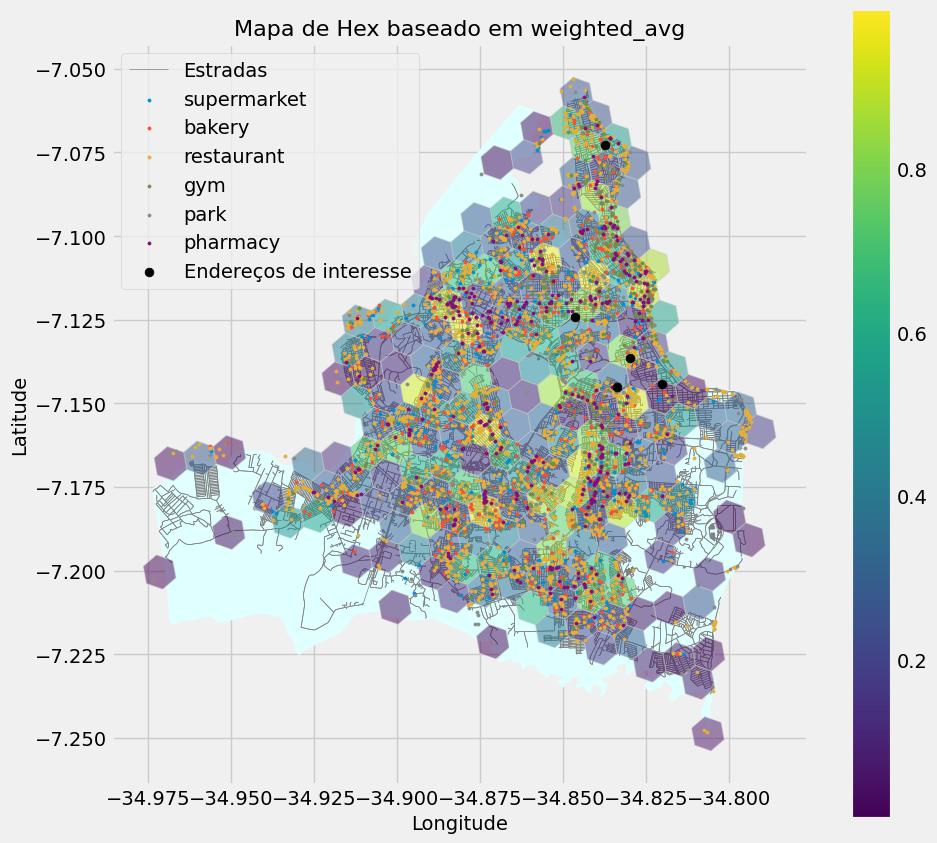

In [22]:
plt.style.use('fivethirtyeight')
# Definir a escala de cores com base nos valores da coluna 'weighted_avg'
vmin, vmax = df_hex_select['weighted_avg'].min(), df_hex_select['weighted_avg'].max()
cmap = 'viridis'  # Você pode escolher outra paleta de cores

# Criar um subplot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plotar o GeoDataFrame usando uma escala de cores

area.plot(ax=ax , color='lightcyan', linewidth=1, label='Area',zorder=1)

edges_proj.plot(ax=ax , color='gray', linewidth=0.5, label='Estradas',zorder=1)

df_hex_select.plot(column='weighted_avg', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8', vmin=vmin, vmax=vmax , alpha=0.5)


for type_plot_place in types:
  full_places_city_select[full_places_city_select['main_type']==type_plot_place].plot(ax=ax , linewidth=0.5, label=type_plot_place,zorder=1 , markersize=5)

enderecos_gpd.plot(ax=ax , color='black', linewidth=0.5, label='Endereços de interesse',zorder=1 , markersize=40)

# Adicionar barra de cores
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = plt.colorbar(sm, ax=ax)

# Adicionar título e rótulos
plt.title('Mapa de Hex baseado em weighted_avg', size=16)
plt.xlabel('Longitude', size=14)
plt.ylabel('Latitude', size=14)
plt.legend()
# Exibir o mapa
plt.show()


In [23]:
# distribuion_serie - Plota gráficos de barras com as contagens de diferentes colunas, agrupadas por categoria.
def distribuion_serie(df,name_serie,hue=None,figsize=(10, 16)):
  """
  Plota gráficos de barras com as contagens de diferentes colunas, agrupadas por categoria.
  Parâmetros
  ----------
  df : pandas.DataFrame
      DataFrame de entrada.
  name_serie : str
      Nome da série a ser plotada.
  hue : str, optional
      Nome da coluna a ser usada para agrupar os dados.
  figsize : tuple, optional
      Tamanho da figura.
  """
  fig, ax = plt.subplots(3,figsize=figsize)
  fig.subplots_adjust(wspace=0.6)
  fig.subplots_adjust(hspace=0.6)
  ax[0] = sns.histplot(df,x=name_serie,ax=ax[0],hue=hue,kde=True)
  ax[0].set(xlabel=f"{name_serie}", ylabel="Frequência")
  ax[0].set_title(f"{name_serie} , DistPlot")

  ax[1] = sns.ecdfplot(df,x=name_serie,
                       hue=hue,
                       ax=ax[1])
  ax[1].set(xlabel=f"{name_serie} comulativo", ylabel="% comulative")
  ax[1].set_title(f"{name_serie}")
  if hue==None:
    ax[2] = sns.boxplot(x=df[name_serie])
  else:
    ax[2] = sns.boxplot(x=df[name_serie],  y=df[hue])
  ax[2].set(xlabel=f"{name_serie}")
  ax[2].set_title(f"Distribuição da {name_serie}")
  fig.show()
  if hue==None:
    display(df[name_serie].describe())
  else:
    display(df[[name_serie,hue]].groupby(hue).describe().sort_values((name_serie,'mean')))

In [24]:
cluster_variables =[i+"_aj" for i in types] # os mesmos  que foram usados para capturar os dados na API do Google
df_cluster = df_hex_select[cluster_variables]
df_cluster.describe()
# for i in df_cluster.columns:
#   distribuion_serie(df_cluster,i,hue=None,figsize=(5, 8))
# sns.pairplot(df_cluster)
# plt.show()

,supermarket_aj,bakery_aj,restaurant_aj,gym_aj,park_aj,pharmacy_aj
count,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000
mean,2.371859,2.969849,7.678392,2.311558,1.442211,1.793970
std,3.413049,3.776468,3.484031,3.416155,2.334508,3.040595
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,10.000000,0.000000,0.000000,0.000000
75%,3.500000,5.000000,10.000000,3.000000,2.000000,2.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


# Cluster

Existem uma grande variedade de tipos de clusterização, na [documentação](https://scikit-learn.org/stable/modules/clustering.html#overview-of-clustering-methods) do scikit-learn é apresentada um breve resumo de algumas delas. O Cluster amplamente conhecido e simples é o KMeans, ele trabalha melhor em geometria plana (duas dimensões) e com pouca quantidade de clusters, para conseguir usa-lo vai ser preciso reduzir a quantidade de features para 2.




In [32]:
from sklearn.cluster import AgglomerativeClustering , KMeans , SpectralClustering
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA


from yellowbrick.cluster import KElbowVisualizer ,silhouette_visualizer

## Redução de dimensionalidade - PCA

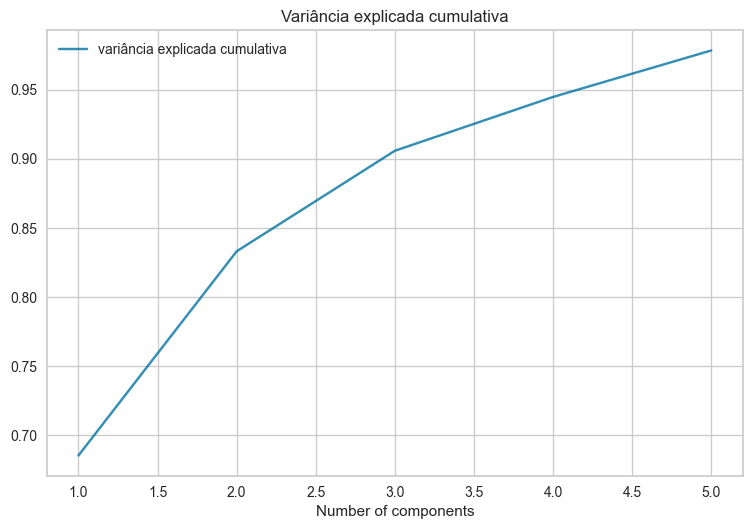

C:\Users\chpsi\AppData\Local\Temp\ipykernel_85220\3364931753.py:74: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


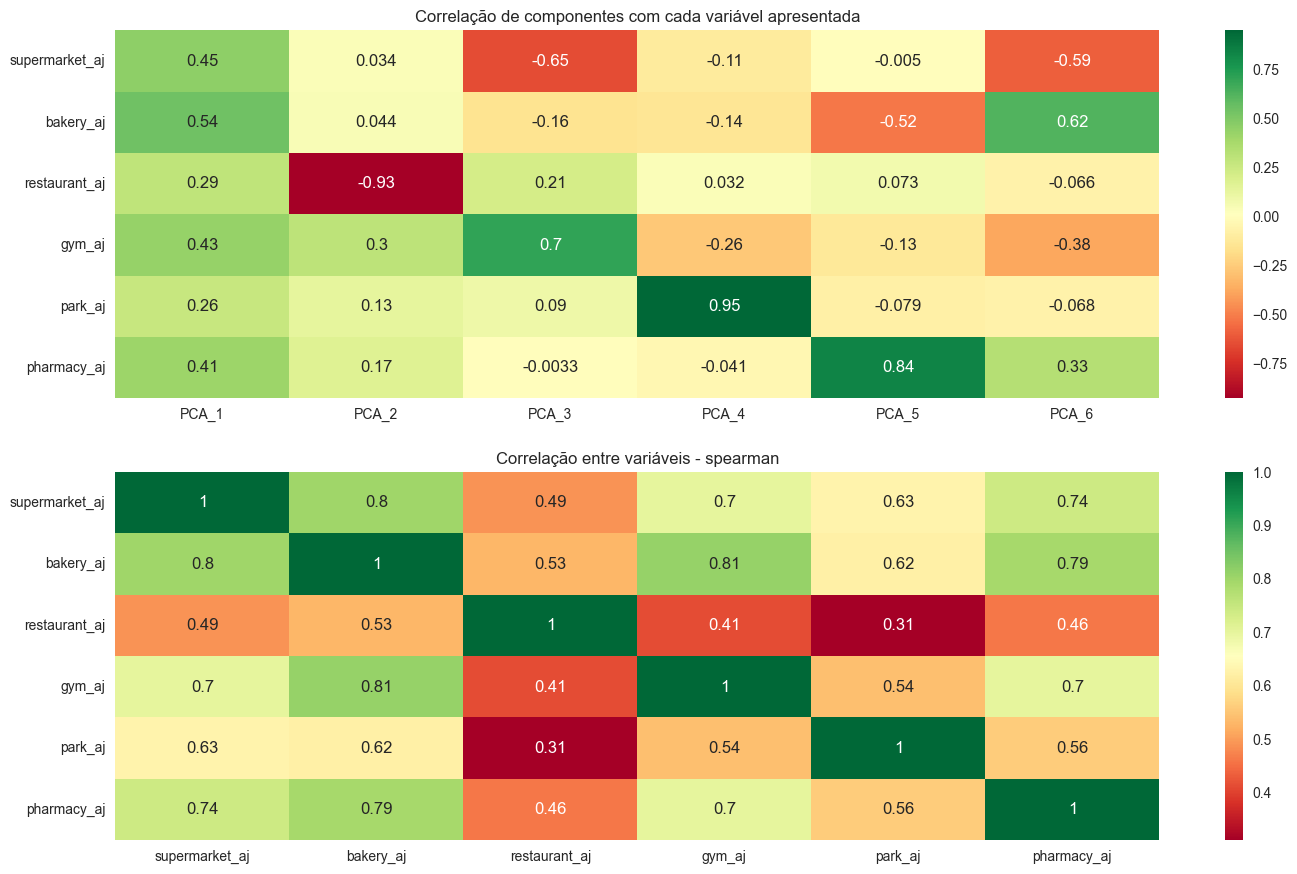

In [33]:

# Reescalonamento de variáveis
clusters_df = df_cluster.reset_index(drop=True)

# clusters_df_MinMax = preprocessing.MinMaxScaler().fit_transform(to_clusters_df)
# clusters_df_MinMax = pd.DataFrame(clusters_df_MinMax, columns=list(to_clusters_df.columns),index=clusters_df.index)


# Aplicando o PCA
n_components = len(clusters_df.columns)
pca = PCA(n_components=n_components)
principalComponents = pca.fit_transform(clusters_df)


########### explained variance and variância explicada cumulativa ############
exp_variance = pca.explained_variance_ratio_
df_variance = pd.Series(exp_variance, name="explained variance")
df_cum_variance = pd.Series(
    np.cumsum(exp_variance), name="variância explicada cumulativa"
)
df_comp = pd.Series(np.arange(1, clusters_df.shape[1]), name="Number of components")
pca_df = pd.concat([df_variance, df_cum_variance, df_comp], axis=1)

pca_df.plot(kind='line', y='variância explicada cumulativa', x='Number of components', alpha=.8)
plt.title('Variância explicada cumulativa')
plt.show()

# display(pca_df)


########################
components = pca.components_
pca_data_explained_var = pd.DataFrame(
    principalComponents,
    columns=["PCA_" + str(i) for i in list(np.arange(1, n_components + 1))],
)
# display(pca_data_explained_var)


componentesTable = pd.DataFrame(
    components.T,
    index=clusters_df.columns,
    columns=["PCA_" + str(i) for i in list(np.arange(1, n_components + 1))],
)
componentesTable = componentesTable

PrincipalComponents = pd.DataFrame(
    components.T,
    index=clusters_df.columns,
    columns=["PCA_" + str(i) for i in list(np.arange(1, n_components + 1))],
)
PrincipalComponents = PrincipalComponents


fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15, 10), sharey=True)

# display(PrincipalComponents.reset_index())

ax1.set_title("Correlação de componentes com cada variável apresentada")
sns.heatmap(
    PrincipalComponents,
    annot=True,
    cmap="RdYlGn",
    ax=ax1,
)

ax2.set_title("Correlação entre variáveis - spearman")
sns.heatmap(
    round(clusters_df.corr(method="spearman"), 2),
    annot=True,
    cmap="RdYlGn",
    ax=ax2,
)

fig.show()

## Selecionando a quantidade de Clusters
# Metricas de Agrupamento e Separação
[**Silhueta (agrupamento)**](https://en.wikipedia.org/wiki/Silhouette_(clustering)

Silhouette refere-se a um método de interpretação e validação de consistência dentro de grupos de dados . O valor da silhueta é uma medida de quão semelhante um objeto é ao seu próprio cluster (coesão) em comparação com outros clusters (separação). **A silhueta varia de -1 a +1, onde um valor alto indica que o objeto é bem compatível com seu próprio cluster e mal combinado com os clusters vizinhos.** Se a maioria dos objetos tiver um valor alto, a configuração de agrupamento será apropriada. Se muitos pontos tiverem um valor baixo ou negativo, a configuração de clustering pode ter muitos ou poucos clusters.

[**Índice de Davies–Bouldin**](https://en.wikipedia.org/wiki/Davies%E2%80%93Bouldin_index)

O índice Davies–Bouldin (DBI) , introduzido por David L. Davies e Donald W. Bouldin em 1979, é uma métrica para avaliar algoritmos de agrupamento . Este é um esquema de avaliação interna, onde a validação de quão bem o agrupamento foi feito é feita usando quantidades e características inerentes ao conjunto de dados. Isso tem a desvantagem de que um bom valor relatado por esse método não implica na melhor recuperação de informações. \
Pela forma como é definido, em função da _razão entre a dispersão dentro do cluster e a separação entre os clusters_, **um valor menor significará que o clustering é melhor**.

[**Calinski-Harabasz**](https://www.geeksforgeeks.org/calinski-harabasz-index-cluster-validity-indices-set-3/)

O índice Calinski-Harabasz pode ser usado para avaliar o modelo quando os rótulos de verdade não são conhecidos onde a validação de quão bem o clustering foi feito é feita usando quantidades e recursos inerentes ao conjunto de dados. O Índice CH (também conhecido como critério de razão de variância ) é uma medida de quão semelhante um objeto é ao seu próprio cluster (coesão) em comparação com outros clusters (separação). Aqui, a coesão é estimada com base nas distâncias dos pontos de dados em um cluster até o centróide do cluster e a separação é baseada na distância dos centróides do cluster do centróide global. \
**Um valor mais alto do índice CH significa que os clusters são densos e bem separados, embora não haja um valor de corte “aceitável”.** Precisamos escolher aquela solução que dá um pico ou pelo menos um cotovelo abrupto no gráfico de linha dos índices CH. Por outro lado, se a linha for suave (horizontal ou ascendente ou descendente), não há razão para preferir uma solução em detrimento de outras.

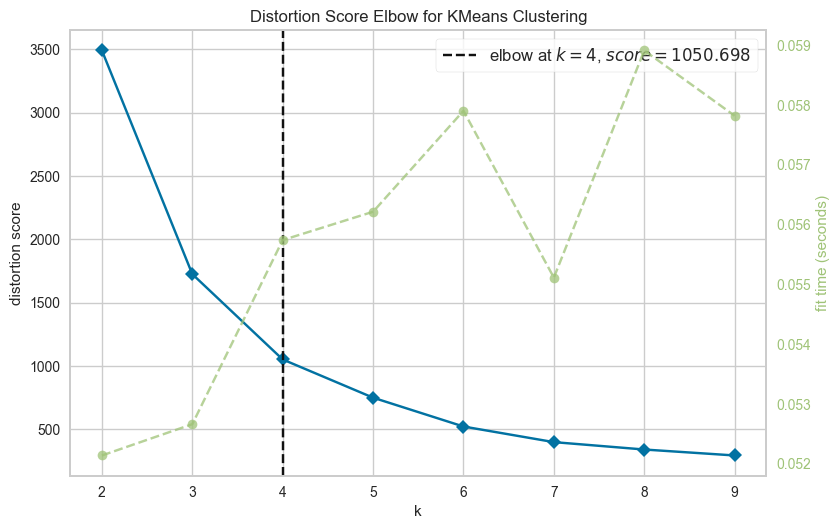

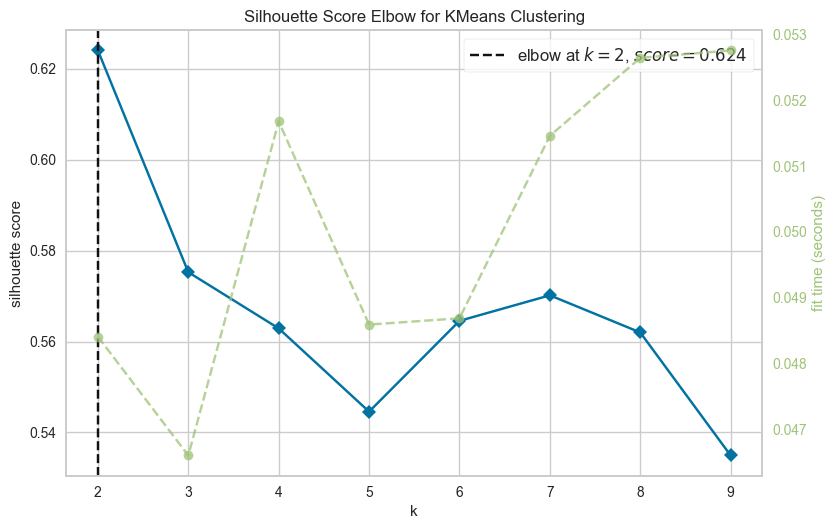

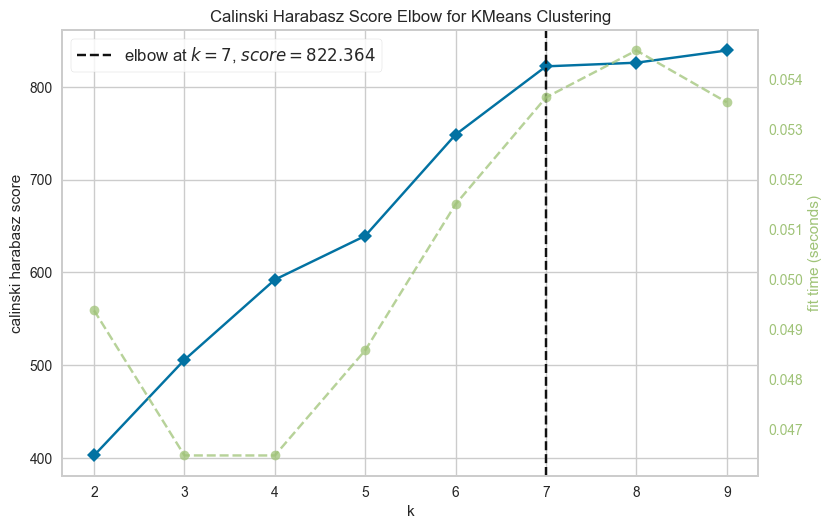

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [38]:
sc = KMeans(n_init=10)

#O valor com a diminuiçao menos adrupta geralmente é o mais indicado
grafico_distortion = KElbowVisualizer(sc, k=(2,10) , metric='distortion')
grafico_distortion.fit(pca_data_explained_var.iloc[:,:2])
grafico_distortion.show()

grafico_silhouette = KElbowVisualizer(sc, k=(2,10) , metric='silhouette')
grafico_silhouette.fit(pca_data_explained_var.iloc[:,:2])
grafico_silhouette.show()

grafico_calinski_harabasz = KElbowVisualizer(sc, k=(2,10) , metric='calinski_harabasz')
grafico_calinski_harabasz.fit(pca_data_explained_var.iloc[:,:2])
grafico_calinski_harabasz.show()

## Construindo Cluster

In [35]:
clustering = Pipeline(
    steps=[("PCA", PCA(n_components=2)),
            ("KMeans",KMeans(n_clusters=4))]
)

clustering.fit(df_hex_select[cluster_variables])

df_hex_select['clusters_KMeans'] = clustering['KMeans'].labels_
df_hex_select['clusters_KMeans'] = df_hex_select['clusters_KMeans'].astype(int)
df_hex_select['clusters_KMeans_string'] = df_hex_select['clusters_KMeans'].astype(str)
# df_hex_select.head()

# Avaliando o cluster


## Visualizando o Cluster

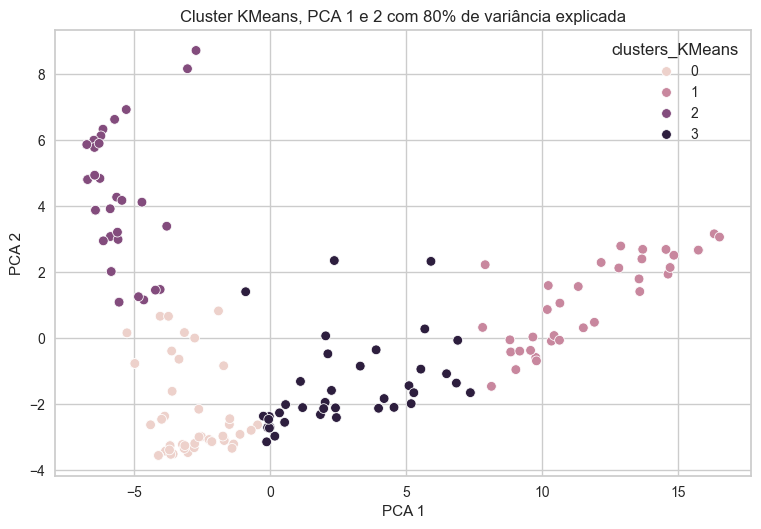

In [36]:
PCA_df = pd.DataFrame(principalComponents , columns=[f"PCA {x+1}" for x in np.arange(0,principalComponents.shape[1])])
PCA_df['clusters_KMeans'] = clustering['KMeans'].labels_
sns.scatterplot(PCA_df , x="PCA 1",y="PCA 2" , hue='clusters_KMeans')
plt.title("Cluster KMeans, PCA 1 e 2 com 80% de variância explicada")
plt.show()



## Gráfico de coordenadas paralelas por cluster

In [40]:
import plotly.express as px

parallel_means = df_hex_select[[
              "weighted_avg","supermarket_aj",
              "bakery_aj","restaurant_aj",
              "gym_aj","park_aj","pharmacy_aj","clusters_KMeans"
               ]].groupby('clusters_KMeans',as_index=False).mean()
# parallel_means['clusters_KMeans'] = parallel_means['clusters_asc].astype(int)

parallel_means = parallel_means.sort_values('weighted_avg',ascending=False).reset_index(drop=True)
parallel_means['rank'] = parallel_means.index + 1
parallel_means['rank_str'] = parallel_means['rank'].astype(str)
px.parallel_coordinates(parallel_means, color='rank').show()
# parallel_means.info()

## GINI dos Clusters

Índice de Gini, é um instrumento para medir o grau de concentração em determinado grupo.

O Coeficiente de Gini consiste em um número entre 0 e 1, onde 0 corresponde à completa igualdade (no caso do rendimento, por exemplo, toda a população recebe o mesmo salário) e 1 corresponde à completa desigualdade (onde uma pessoa recebe todo o rendimento e as demais nada recebem). Levando em conta essa conceituação o que esperamos que após a clusterização as variáveis sejam mais próxima a 0 dentro de um cluster do que no contexto geral.

[Aqui um artigo que uso o conceito de gini para clusters.](https://www.researchgate.net/publication/305795188_Using_Gini_coefficient_to_determining_optimal_cluster_reporting_sizes_for_spatial_scan_statistics)

C:\Users\chpsi\AppData\Local\Temp\ipykernel_85220\3816276060.py:29: RuntimeWarning:

invalid value encountered in scalar divide



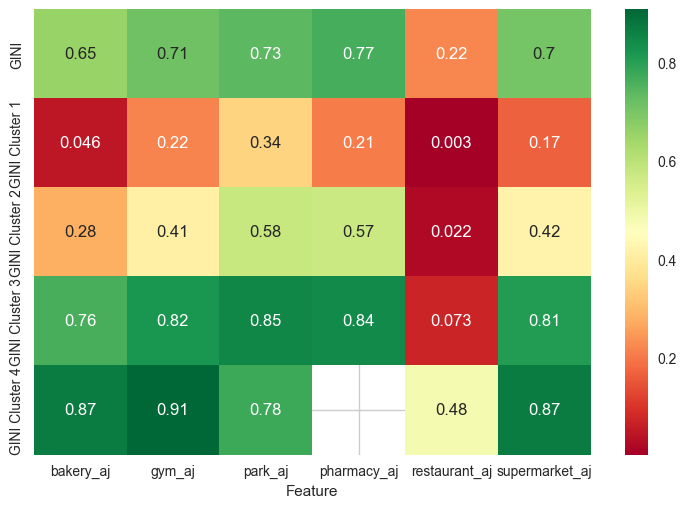

In [41]:
df_hex_select_plot = df_hex_select.merge(parallel_means[['clusters_KMeans','rank_str']],on='clusters_KMeans')
GINI_db_cluster = AvaliateGINI_Clusters(df_hex_select_plot, 'rank_str', cluster_variables)
GINI_db_cluster = GINI_db_cluster.pivot_table(values=['GINI Cluster 3', 'GINI Cluster 1', 'GINI Cluster 2', 'GINI Cluster 4', 'GINI'], index='Feature').T
# sns.heatmap(GINI_db_cluster)

sns.heatmap(
    GINI_db_cluster,
    annot=True,
    cmap="RdYlGn",
)
plt.show()

# Mapa Final

C:\Users\chpsi\AppData\Local\Temp\ipykernel_85220\734530330.py:18: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



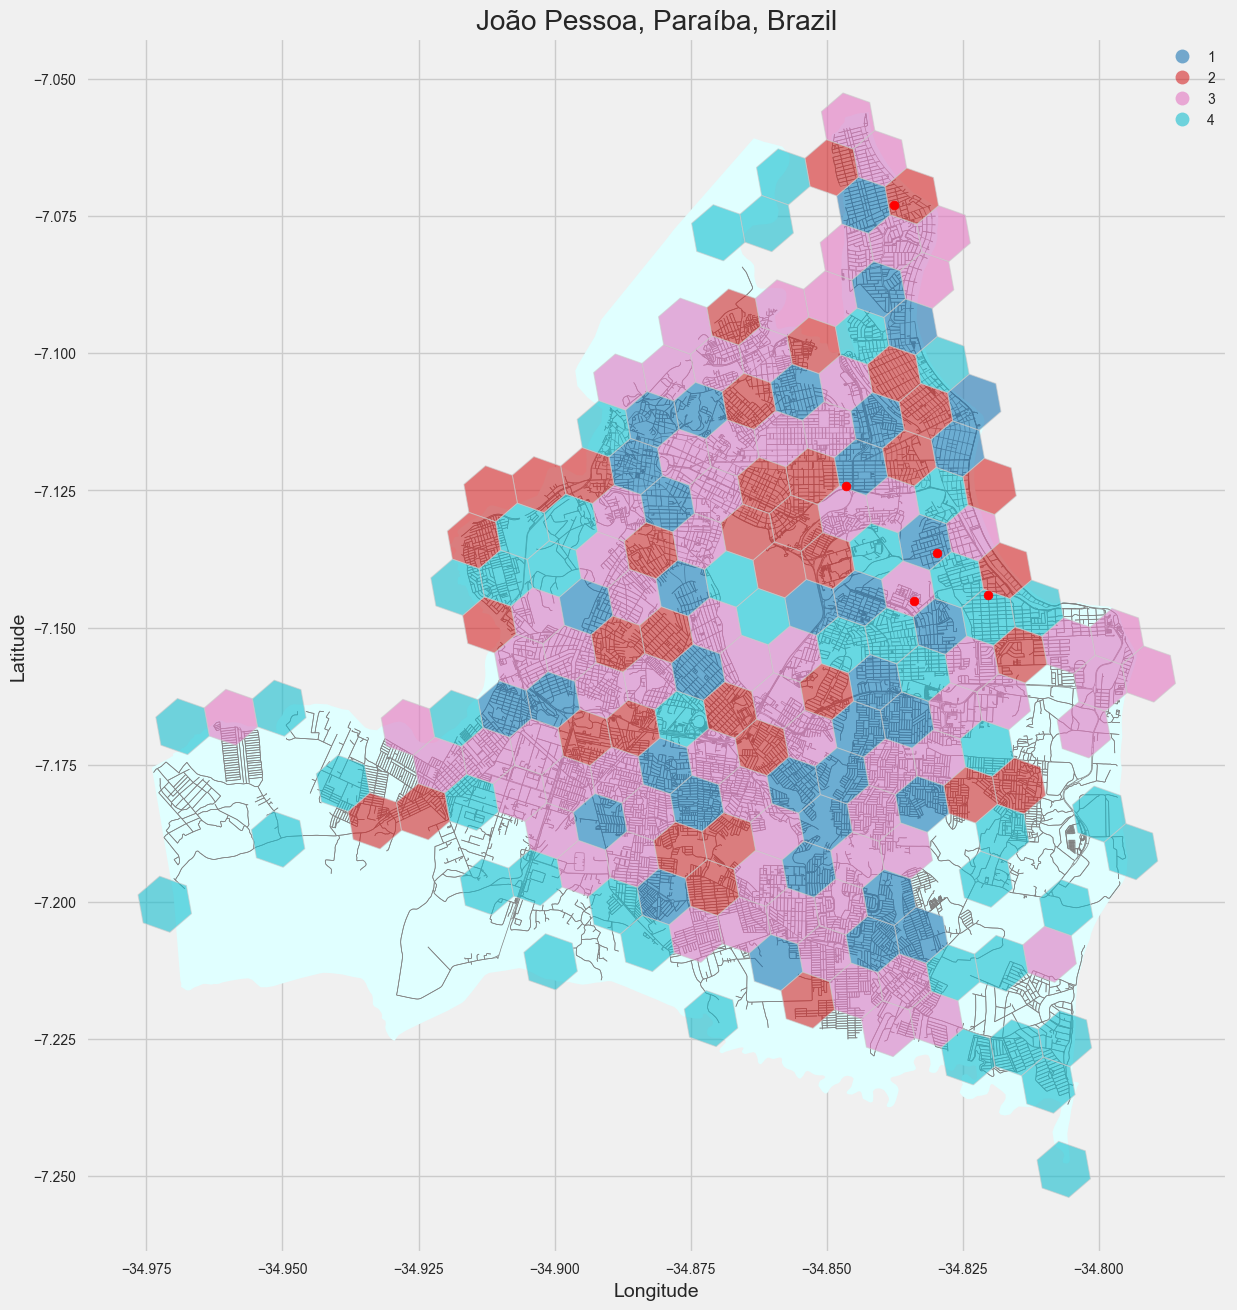

In [42]:

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(15,15))
plt.title(place_name)

area.plot(ax=ax , color='lightcyan', linewidth=1, label='Area',zorder=1)
edges_proj.plot(ax=ax , color='gray', linewidth=0.5, label='Estradas',zorder=1)
df_hex_select_plot.plot(column='rank_str', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True , alpha=0.6)

# gpd.sjoin(df_hex_select_plot, enderecos_gpd, op='intersects').plot(column='clusters_ag', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True , alpha=0.6)
# for type_plot_place in types:
#   full_places_city_select[full_places_city_select['main_type']==type_plot_place].plot(ax=ax , linewidth=0.5, label=type_plot_place,zorder=1 , markersize=5)

enderecos_gpd.plot(ax=ax , color='red', linewidth=0.5, label='Endereços de interesse',zorder=1 , markersize=40)
# nodes_proj.plot(ax=ax , color='red',label='Nós',markersize=1,zorder=2)
plt.xlabel('Longitude', size=14)
plt.ylabel('Latitude', size=14)
# plt.legend()
fig.show()

In [30]:
df_hex_select_plot

,geometry,hex8_code,bakery,gym,park,pharmacy,restaurant,supermarket,supermarket_aj,bakery_aj,restaurant_aj,gym_aj,park_aj,pharmacy_aj,weighted_avg,clusters_KMeans,clusters_KMeans_string,rank_str
0,"POLYGON ((-34.83926 -7.06960, -34.83529 -7.066...",8881836543fffff,0,0,0,1,14,0,0,0,10,0,0,1,0.255,0,0,3
1,"POLYGON ((-34.80179 -7.17379, -34.79782 -7.170...",88818362ebfffff,0,0,2,0,15,1,1,0,10,0,2,0,0.285,0,0,3
2,"POLYGON ((-34.88437 -7.14961, -34.88039 -7.146...",88818375bbfffff,0,0,0,0,14,0,0,0,10,0,0,0,0.250,0,0,3
3,"POLYGON ((-34.85770 -7.14459, -34.85373 -7.141...",8881836749fffff,2,2,3,0,20,3,3,2,10,2,3,0,0.420,0,0,3
4,"POLYGON ((-34.81371 -7.18398, -34.80974 -7.180...",88818362c1fffff,1,0,1,0,15,7,7,1,10,0,1,0,0.440,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,"POLYGON ((-34.86007 -7.08146, -34.85610 -7.078...",8881836733fffff,1,1,0,0,3,3,3,1,3,1,0,0,0.190,3,3,4
195,"POLYGON ((-34.89607 -7.13591, -34.89210 -7.132...",8881836661fffff,2,1,0,0,5,0,0,2,5,1,0,0,0.175,3,3,4
196,"POLYGON ((-34.86074 -7.15311, -34.85677 -7.149...",88818375a3fffff,0,0,0,0,2,0,0,0,2,0,0,0,0.050,3,3,4
197,"POLYGON ((-34.96743 -7.17317, -34.96345 -7.169...",888183749bfffff,0,0,1,0,1,0,0,0,1,0,1,0,0.030,3,3,4
